# Runtime Measurments

Anaylization of runtime behaviour of functions in cuCV vs CPU singlethread and openCV.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
COUNTS = [1,2,4,8]
LOGS_DIR = "logs"
ADDITION_LOGS = [os.path.join(LOGS_DIR, f"addition_{counts}B.csv") for counts in COUNTS]
MATMUL_LOGS = [os.path.join(LOGS_DIR, f"matmul_{counts}B.csv") for counts in COUNTS]
CONV_LOGS = [os.path.join(LOGS_DIR, f"convolution_{counts}B.csv") for counts in COUNTS]
MARKERS = ['+', 'x', 'd', '*', '<', 'o','.', '>', '^', 'v'] * 10
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 10

In [4]:
def get_c(id):
    if id == 0:
        return '#17becf'
    elif id == 99:
        return '#9467bd'
    else:
        return None

### Arithemtic Operations
Analyze the Runtime of Arithmetic Operations

In [22]:
ADD_DEVICES = {0:"simple CPU", 1:"CUDA w/ DT", 2:"CUDA wo/ DT", 3:"CUDA w/ DT sharedMem", 4:"CUDA wo/ DT sharedMem", 99:"openCV"}  # copied from log
ADD_data_per_type = {"CUCV_8U":[], "CUCV_16U":[], "CUCV_32F":[], "CUCV_64F":[]}

In [51]:

for i, dtype in enumerate(ADD_data_per_type.keys()):
    if not os.path.exists(ADDITION_LOGS[i]):
        break
    ds = pd.read_csv(ADDITION_LOGS[i], sep=";", skipinitialspace=True, skiprows=[1])
    groupby_device = ds.groupby(by="Device")  # groupby Device

    dfs_over_N = []

    for id, df in groupby_device:
        groupby_dev_mean = df.groupby(by='N').mean().reset_index()  # groupby Size and get mean value over Runs
        groupby_dev_mean.drop(["Run"], axis=1, inplace=True) # drop column Run
        # Add a column containing the Performance Rate in MPix/s
        groupby_dev_mean["MPix/s"] = groupby_dev_mean["N"]**2/ groupby_dev_mean["Time"] * (10**9)/(1024**2)
        dfs_over_N.append(groupby_dev_mean)
    
    ADD_data_per_type[dtype] = dfs_over_N


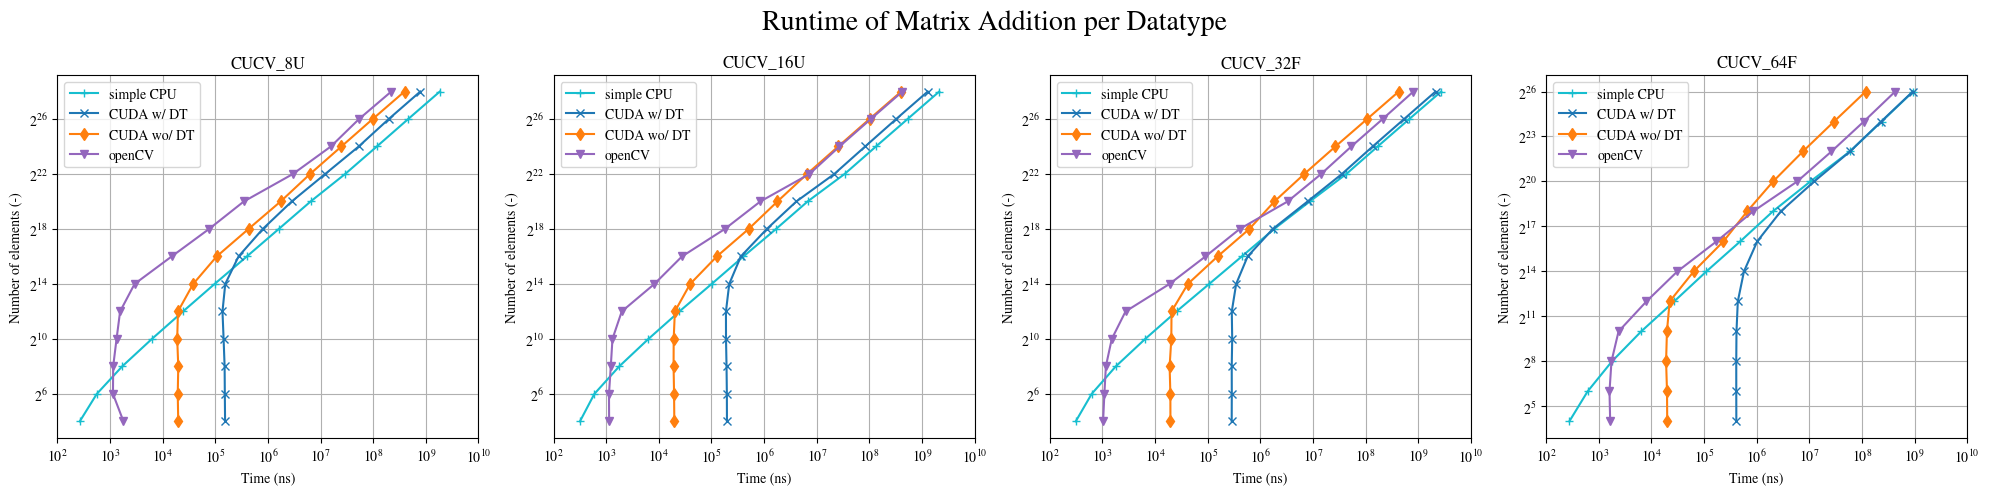

In [50]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs = axs.flatten()

for i, ax in enumerate(axs):
    for df in list(ADD_data_per_type.values())[i]:
        id = int(df["Device"].iloc[0])
        ax.plot(df["Time"], df["N"]**2, marker=MARKERS[id], c=get_c(id), label=ADD_DEVICES[id])

    ax.grid()
    ax.set_xscale("log")
    ax.set_xticks([10**i for i in np.arange(2, 11,)])
    ax.set_yticks([2**i for i in np.arange(0, 40)])
    ax.set_yscale("log", base=2)
    ax.legend()
    dtype = list(ADD_data_per_type.keys())[i]
    ax.set(title=f"{dtype}", xlabel="Time (ns)", ylabel="Number of elements (-)")
fig.suptitle("Runtime of Matrix Addition per Datatype", fontsize=20);
fig.tight_layout()
fig.savefig("plots/addition.png")

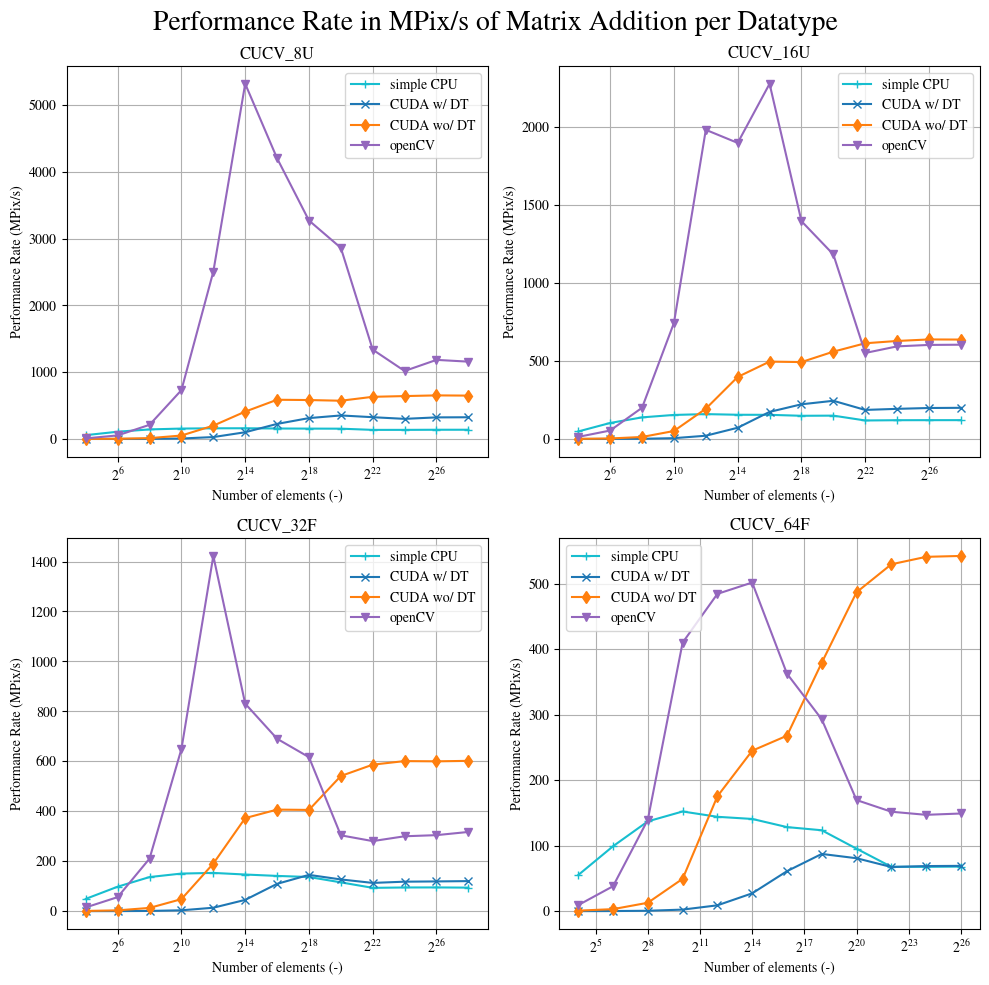

In [64]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.flatten()

for i, ax in enumerate(axs):
    for df in list(ADD_data_per_type.values())[i]:
        id = int(df["Device"].iloc[0])
        ax.plot(df["N"]**2, df["MPix/s"], marker=MARKERS[id], c=get_c(id), label=ADD_DEVICES[id])

    ax.grid()
    ax.set_xticks([2**i for i in np.arange(0, 40)])
    ax.set_xscale("log", base=2)
    ax.legend()
    dtype = list(ADD_data_per_type.keys())[i]
    ax.set(title=f"{dtype}", xlabel="Number of elements (-)", ylabel="Performance Rate (MPix/s)")
fig.suptitle(r"Performance Rate in MPix/s of Matrix Addition per Datatype", fontsize=20);
fig.tight_layout()
fig.savefig("plots/addition_MPix.pdf")

Make one plot per Function and plot per datatype such that it is possible to compare influence of datatype

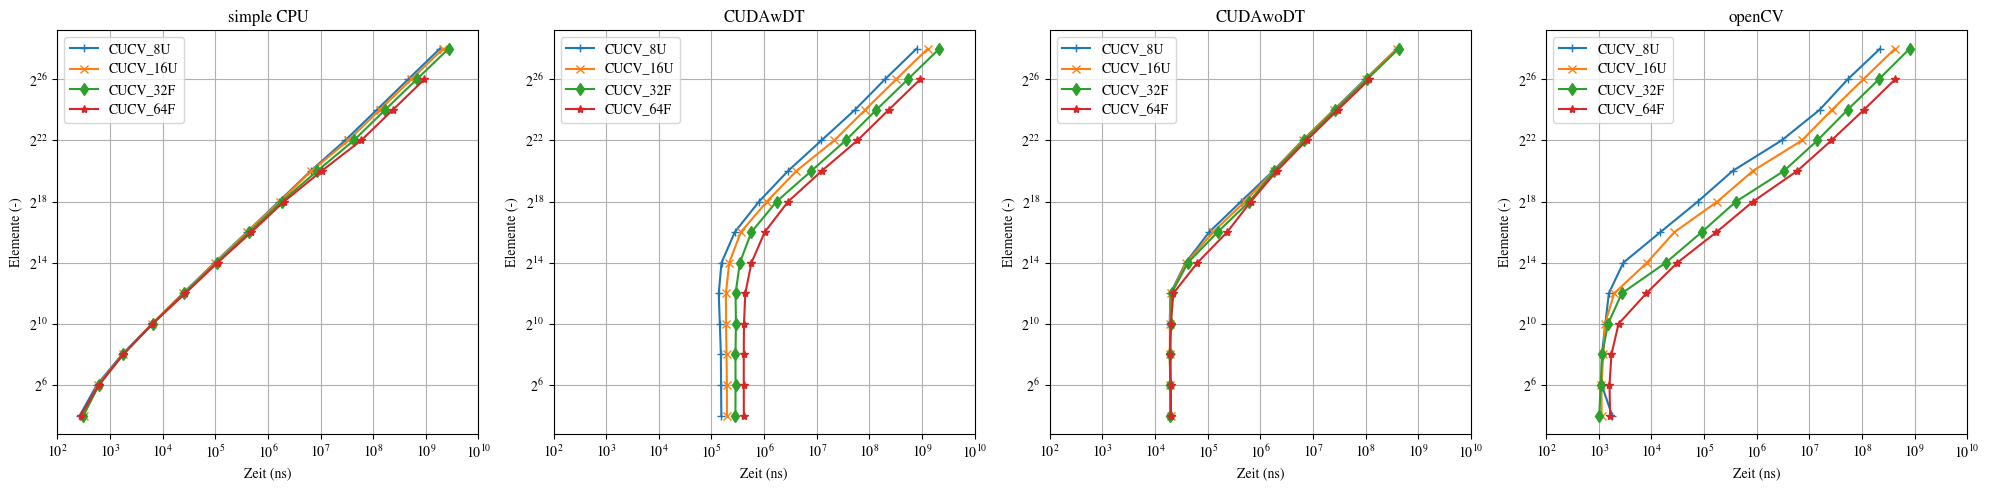

In [8]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs = axs.flatten()

for i, ax in enumerate(axs):
    for j, l_of_types in enumerate(list(ADD_data_per_type.values())):
        df = l_of_types[i]
        p = ax.plot(df["Time"], df["N"]**2, marker=MARKERS[j], c=COLORS[j], label=list(ADD_data_per_type.keys())[j])
        dev = ADD_DEVICES[df["Device"].iloc[i]]
    ax.grid()
    ax.set_xscale("log")
    ax.set_xticks([10**i for i in np.arange(2, 11,)])
    ax.set_yscale("log", base=2)
    ax.legend()
    ax.set(title=ADD_DEVICES[df["Device"].iloc[i]], xlabel="Zeit (ns)", ylabel="Elemente (-)")
fig.tight_layout()

### Matrix Multiplikation

In [73]:
MATMUL_DEVICES = {0:"simple CPU", 1:"CUDA w/ DT", 2:"CUDA wo/ DT", 3:"CUDA w/ DT sharedMem", 4:"CUDA wo/ DT sharedMem", 99:"openCV"}   # copied from log
MATMUL_data_per_type = {"CUCV_8U":[], "CUCV_16U":[], "CUCV_32F":[], "CUCV_64F":[]}

In [74]:

for i, dtype in enumerate(MATMUL_data_per_type.keys()):
    if not os.path.exists(MATMUL_LOGS[i]):
        break
    ds = pd.read_csv(MATMUL_LOGS[i], sep=";", skipinitialspace=True, skiprows=[1])
    groupby_device = ds.groupby(by="Device")  # groupby Device

    dfs_over_N = []

    for id, df in groupby_device:
        groupby_dev_mean = df.groupby(by='N').mean().reset_index()  # groupby Size and get mean value
        groupby_dev_mean.drop(["Run"], axis=1, inplace=True)  # drop Column Run as its not needed anymore
        # Add a column containing the effektive bandwidth in MB/s
        # Two reads of Matrices and one Write. Kernel is assumend to be of float32
        groupby_dev_mean["MB/s"] = (groupby_dev_mean["N"]**2 * 3 * COUNTS[i]) / groupby_dev_mean["Time"] * (10**9)/(1024**2)
        # Add a column containing the number of output pixels per time
        groupby_dev_mean["MPix/s"] = groupby_dev_mean["N"]**2 / groupby_dev_mean["Time"] * (10**9)/(1024**2)
        dfs_over_N.append(groupby_dev_mean)
    
    MATMUL_data_per_type[dtype] = dfs_over_N

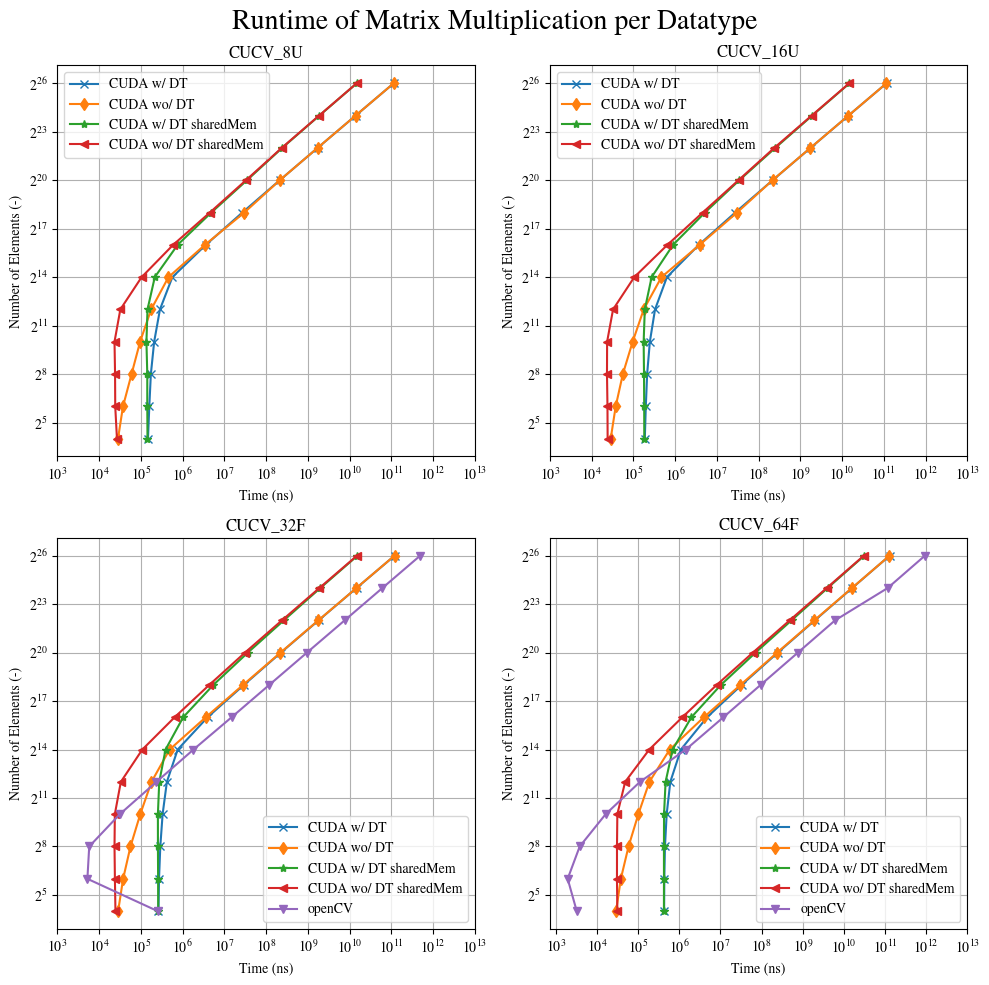

In [76]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.flatten()

for i, ax in enumerate(axs):
    i += 0
    for df in list(MATMUL_data_per_type.values())[i]:
        id = int(df["Device"].iloc[0])
        ax.plot(df["Time"], df["N"]**2, marker=MARKERS[id], c=get_c(id), label=MATMUL_DEVICES[id])

    ax.grid()
    ax.set_xscale("log")
    ax.set_xticks([10**i for i in np.arange(3, 14,)])
    ax.set_yscale("log", base=2)
    ax.legend()
    ax.set(title=list(MATMUL_data_per_type.keys())[i], xlabel="Time (ns)", ylabel="Number of Elements (-)")
fig.suptitle(r"Runtime of Matrix Multiplication per Datatype", fontsize=20);
fig.tight_layout()
fig.savefig("plots/matmul.pdf")


### Convolution

In [77]:
CONV_DEVICES = {0:'simple CPU',1:'simpleConv2DwDT',2:'simpleConv2DwoDT',3:'simpleSharedConv2DwDT', \
        4:'simpleSharedConv2DwoDT',5:'sharedPaddingConv2DwDT',6:'sharedPaddingConv2DwoDT',7:'sepSharedConv2DwDT',8:'sepSharedConv2DwoDT',99:'openCV'} # copied from log
CONV_data_per_type = {"CUCV_8U":[], "CUCV_16U":[], "CUCV_32F":[], "CUCV_64F":[]}
CONV_data_over_M_per_type = {"CUCV_8U":[], "CUCV_16U":[], "CUCV_32F":[], "CUCV_64F":[]}

In [78]:

for i, dtype in enumerate(CONV_data_per_type.keys()):
    if not os.path.exists(CONV_LOGS[i]):
        break
    ds = pd.read_csv(CONV_LOGS[i], sep=";", skipinitialspace=True, skiprows=[1])
    groupby_device = ds.groupby(by="Device")  # groupby Device

    dfs_over_N = []
    dfs_over_M = []

    for id, df in groupby_device:
        groupby_dev_mean = df.groupby(by=['N','M']).mean().reset_index()  # groupby Size and get mean value
        groupby_dev_mean.drop(["Run"], axis=1, inplace=True)  # drop Column Run as its not needed anymore
        # Add a column containing the effektive bandwidth in MB/s
        # Two reads of Matrix and Kernel plus one write. Kernel is assumend to be of float32
        groupby_dev_mean["MB/s"] = (groupby_dev_mean["N"]**2 * 2 * COUNTS[i] + groupby_dev_mean["M"]**2 * 4) / groupby_dev_mean["Time"] * (10**9)/(1024**2)
        # Add a column containing the number of output pixels per time
        groupby_dev_mean["MPix/s"] = groupby_dev_mean["N"]**2 / groupby_dev_mean["Time"] * (10**9)/(1024**2)
        subgroupby_kernel = [df for id, df in groupby_dev_mean.groupby("M")]
        subgroupby_numel  = [df for id, df in groupby_dev_mean.groupby("N")]
        dfs_over_N.append(subgroupby_kernel)
        dfs_over_M.append(subgroupby_numel)
    
    CONV_data_per_type[dtype] = dfs_over_N
    CONV_data_over_M_per_type[dtype] = dfs_over_M

`CONV_data_per_type` is a dictionary, where the values are lists. Entries of the list are grouped by kernel size, meaning it is a stack of dataframes, where every df keeps data of a convolution operation with the same kernel size.

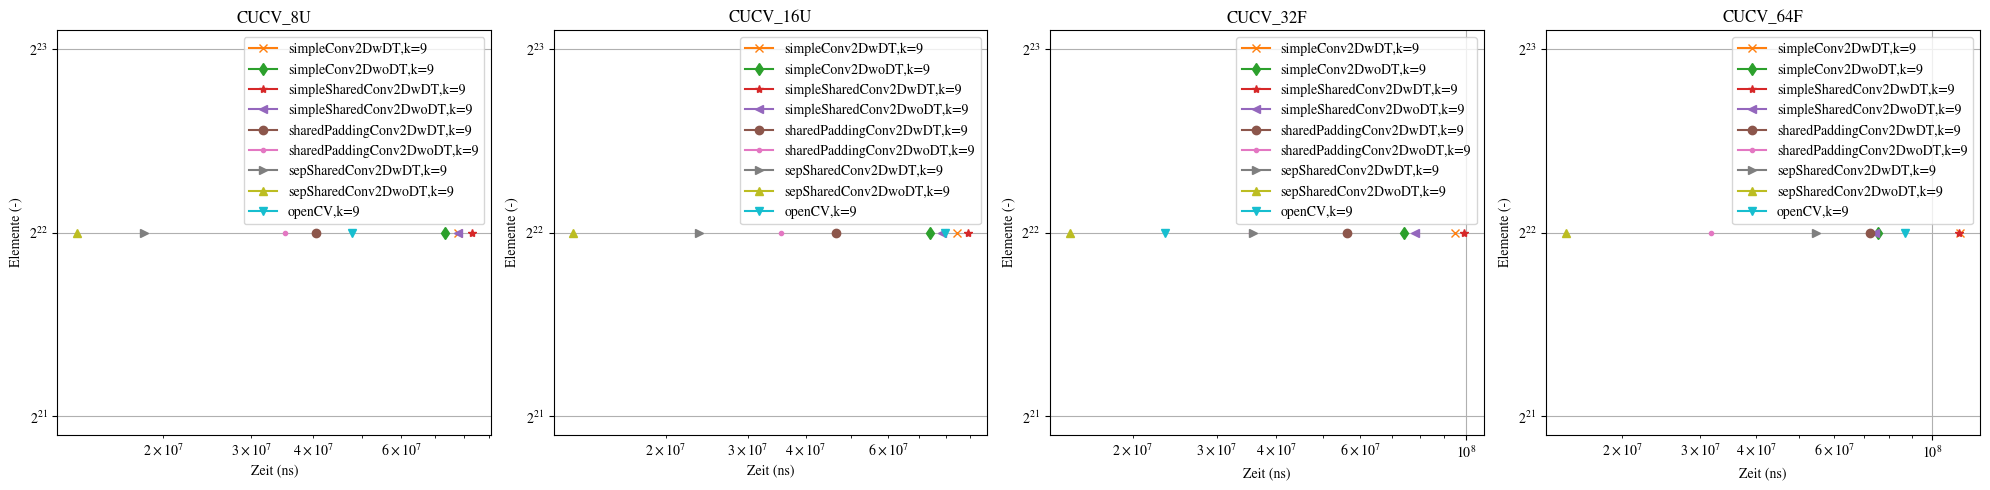

In [79]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs = axs.flatten()

for i, ax in enumerate(axs):
    for l_groupy_kernel in list(CONV_data_per_type.values())[i]:
        for df in l_groupy_kernel:
            kSize = df['M'].iloc[0]
            id = int(df["Device"].iloc[0])
            #if "woDT" not in CONV_DEVICES[id] and kSize == 9:
            if kSize == 9:
                ax.plot(df["Time"], df["N"]**2, marker=MARKERS[id], c=COLORS[id], label=CONV_DEVICES[id]+f",k={kSize}")
                
    ax.grid()
    ax.set_xscale("log", base=10)
    ax.set_yscale("log", base=2)
    ax.legend()
    ax.set(title=list(CONV_data_per_type.keys())[i], xlabel="Zeit (ns)", ylabel="Elemente (-)")
fig.tight_layout()

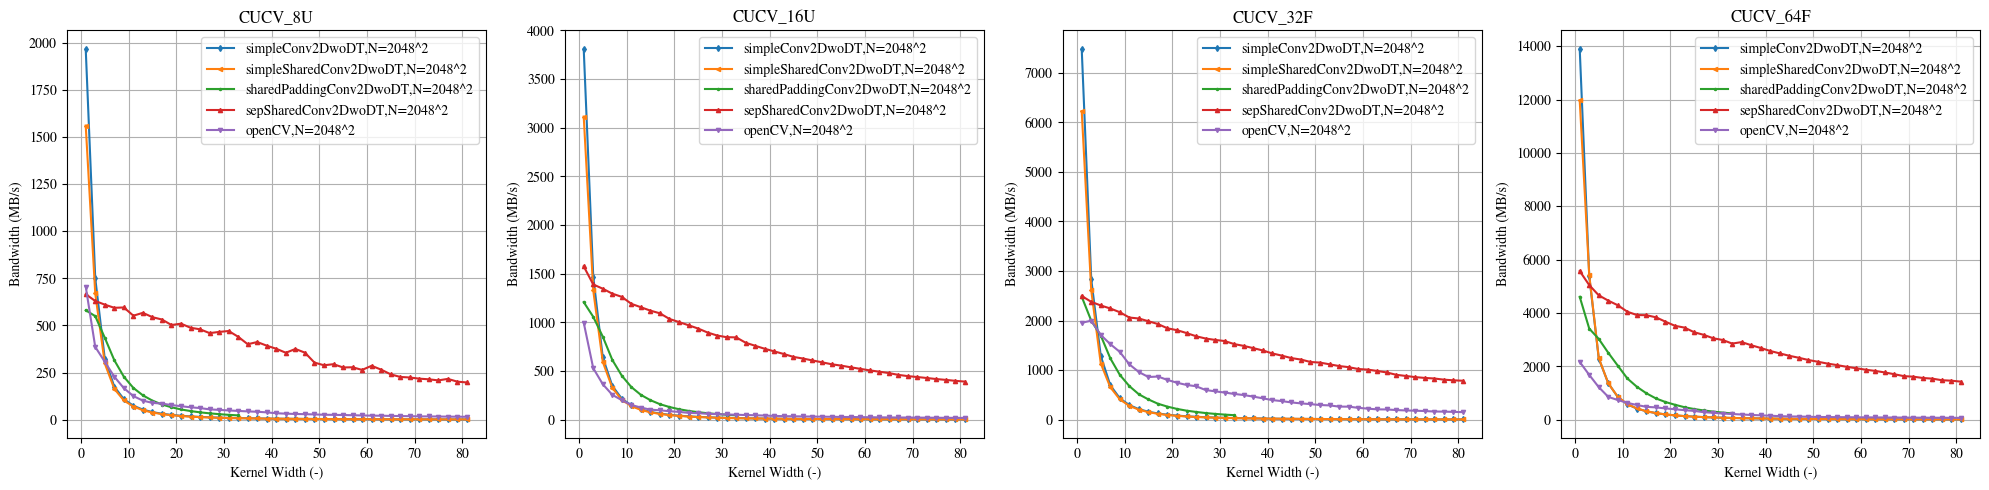

In [80]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs = axs.flatten()

for i, ax in enumerate(axs):
    for l_groupby_numel in list(CONV_data_over_M_per_type.values())[i]:
        for df in l_groupby_numel:
            numel = df['N'].iloc[0]
            id = int(df["Device"].iloc[0])
            if "wDT" not in CONV_DEVICES[id] and numel == 2048:
                ax.plot(df["M"], df["MB/s"], label=CONV_DEVICES[id]+f",N={numel}^2", markersize=3, marker=MARKERS[id], c=None)

    ax.grid()
    #ax.set_xscale("log")
    #ax.set_yscale("log", base=2)
    ax.legend()
    ax.set(title=list(CONV_data_over_M_per_type.keys())[i], xlabel="Kernel Width (-)", ylabel="Bandwidth (MB/s)")
fig.tight_layout()

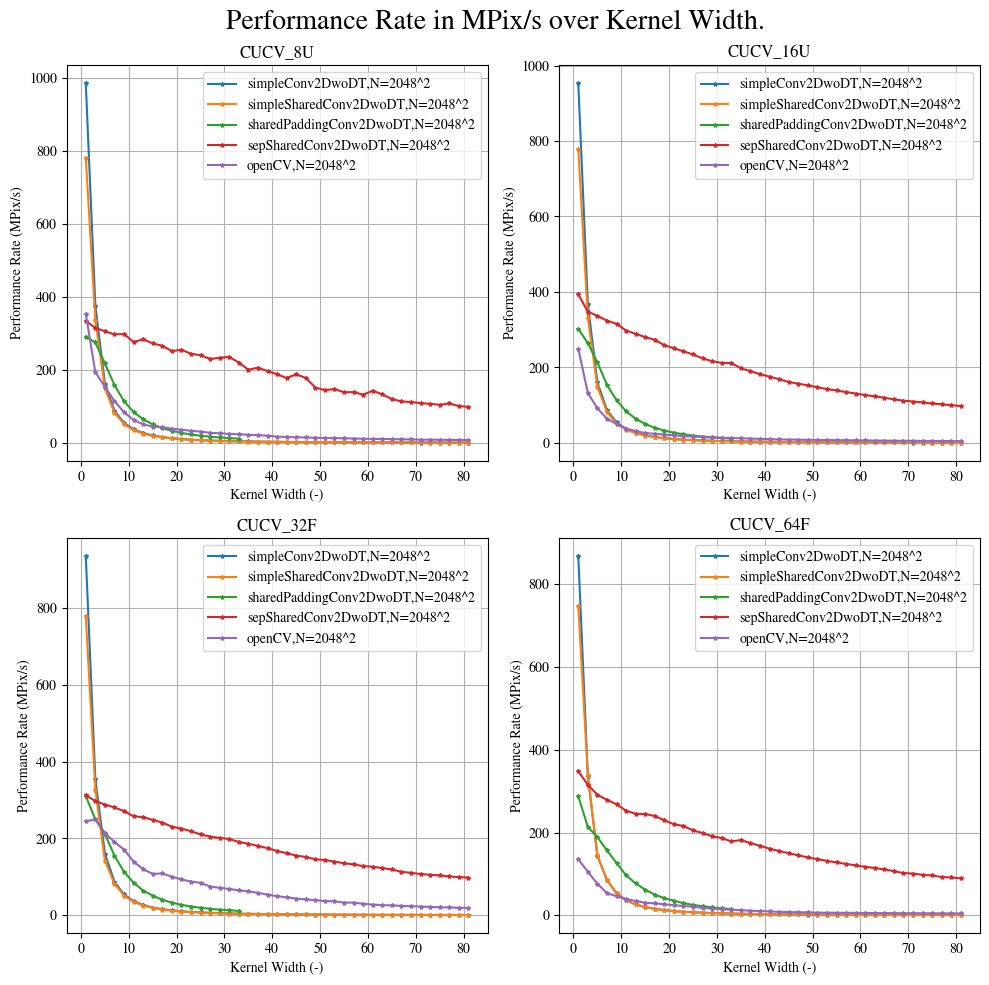

In [82]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.flatten()

for i, ax in enumerate(axs):
    for l_groupby_numel in list(CONV_data_over_M_per_type.values())[i]:
        for df in l_groupby_numel:
            numel = df['N'].iloc[0]
            id = int(df["Device"].iloc[0])
            c = None if id != 99 else '#9467bd'
            if "wDT" not in CONV_DEVICES[id] and numel == 2048:
                ax.plot(df["M"], df["MPix/s"], label=CONV_DEVICES[id]+f",N={numel}^2", markersize=3, marker="*", c=c)

    ax.grid()
    #ax.set_xscale("log")
    #ax.set_yscale("log", base=2)
    ax.legend()
    ax.set(title=list(CONV_data_over_M_per_type.keys())[i], xlabel="Kernel Width (-)", ylabel="Performance Rate (MPix/s)")
fig.suptitle("Performance Rate in MPix/s over Kernel Width.", fontsize=20)
fig.tight_layout()
fig.savefig("plots/conv.pdf")